# additional features

We're going to use the pointcloud file where Hendrik has calculated some geometric features. We'll input this into a model using samples, which we will then pass to Hendrik to utilise on the full sample

Within our new variables we should use r=0.1,0.5, as this determines spatial similarity at different spatial scales. **I need to know if height division is just relative height?**

### Update: 2026-02-02
We've figured out the x and y, even normalised, are the models most important feature by far for classification. We cna infer from this that spatial location/proximity

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns
import open3d as o3d
import pandas as pd
from dotenv import load_dotenv
import json
from upath import UPath
import os
# Load environment variables from .env file if it exists
load_dotenv()
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
#from src import data_loader

sns.set_theme(style="whitegrid")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import psutil
import os

# This cell is just for ensuring I'm utilising the right memory
# Get current process (Jupyter kernel)
process = psutil.Process(os.getpid())
mem_info = process.memory_info()

print(f"Current notebook memory usage:")
print(f"  RSS (resident set): {mem_info.rss / 1e9:.2f} GB")
print(f"  VMS (virtual):      {mem_info.vms / 1e9:.2f} GB")

# Get total system memory
total_mem = psutil.virtual_memory().total / 1e9
used_mem = psutil.virtual_memory().used / 1e9
available = psutil.virtual_memory().available / 1e9

print(f"\nSystem memory:")
print(f"  Total:     {total_mem:.2f} GB")
print(f"  Used:      {used_mem:.2f} GB")
print(f"  Available: {available:.2f} GB")
print(f"  % used:    {psutil.virtual_memory().percent:.1f}%")

Current notebook memory usage:
  RSS (resident set): 0.43 GB
  VMS (virtual):      12.52 GB

System memory:
  Total:     270.13 GB
  Used:      101.77 GB
  Available: 166.42 GB
  % used:    38.4%


In [3]:
# Locate to your local path
DATA_PATH = Path("/media/HDD_disk/james/lidar_REALLOCATE")
DATA_LAZ_PATH = DATA_PATH / "bologna_precalculated_subsampled.laz"

In [4]:
# Disregard this cell, it is just for testing the data loading and processing pipeline.

#data_loader.fetch_and_process_lidar("bologna_precalculated_subsampled.laz")

### Let's remind outselves of the classifications
- 0 not yet classified (nothing done yet)
- 1 unclassified (actively marked as nothing)
- 2 ground, sidewalk
- 3,4,5 vegetation, low(gras) medium(shrubbery) high (trees)
- 6 buildings
- 8 street furniture
- 10 street markings
- 11 street, pavement
- 12 bike lanes
- 13 temporary things(bicycles, trashcans)
- 15 cars, trucks

In [5]:
# build functions to summarise the las file we're working with
import sys

def las_in_memory_size(las):
    """
    Estimate the in-memory size (in bytes) of a laspy LAS object.
    """
    total_size = 0
    for dim in list(las.point_format.dimension_names):
        arr = getattr(las, dim)
        total_size += arr.nbytes if hasattr(arr, 'nbytes') else sys.getsizeof(arr)
    return total_size

# Example usage:
# las = laspy.read("your_file.las")
# print(f"In-memory size: {las_in_memory_size(las)/1e6:.2f} MB")

def describe_las(las):
    print(f"In-memory size: {las_in_memory_size(las)/1e6:.2f} MB")
    print(f"Point Format: {las.header.point_format}")
    print(f"Number of Points: {las.header.point_count}")
    print("Available Dimensions:", list(las.point_format.dimension_names))
    print("Bounding Box:")
    print(f"  X: {las.header.mins[0]} to {las.header.maxs[0]}")
    print(f"  Y: {las.header.mins[1]} to {las.header.maxs[1]}")
    print(f"  Z: {las.header.mins[2]} to {las.header.maxs[2]}")
    print("Scale:", las.header.scales)
    print("Offset:", las.header.offsets)
    try:
        print("CRS:", las.header.parse_crs())
    except:
        print("CRS: Not defined")

In [6]:
# Read in the las
las = laspy.read(DATA_LAZ_PATH)

In [7]:
describe_las(las)

In-memory size: 2084.76 MB
Point Format: <PointFormat(3, 116 bytes of extra dims)>
Number of Points: 14086232
Available Dimensions: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'height_division', 'Roughness (0.1)', 'Normal change rate (0.1)', 'Surface density (r=0.1)', 'Volume density (r=0.1)', 'Planarity (0.1)', 'Sphericity (0.1)', 'Verticality (0.1)', 'Roughness (0.05)', 'Normal change rate (0.05)', 'Surface density (r=0.05)', 'Volume density (r=0.05)', 'Planarity (0.05)', 'Sphericity (0.05)', 'Verticality (0.05)', 'Roughness (0.5)', 'Normal change rate (0.5)', 'Surface density (r=0.5)', 'Volume density (r=0.5)', 'Planarity (0.5)', 'Sphericity (0.5)', 'Verticality (0.5)', 'Roughness (1)', 'Normal change rate (1)', 'Surface density (r=1)', 'Volume density (r=1)', 'Planarity (1)

### Feature selection

We are going to start with a lot of features. some of these may eventually be filtered out due to multicollinearity or poor feature importance. We expect a high computational effort at first.

In [8]:
from laspy import read
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Fields of interest
fields = ['X', 'Y', 'Z', 'intensity',
        'classification', 'red', 'green', 'blue',
        'height_division', 'Roughness (0.1)', 'Normal change rate (0.1)',
        'Surface density (r=0.1)', 'Volume density (r=0.1)', 'Planarity (0.1)',
        'Sphericity (0.1)', 'Verticality (0.1)', 'Roughness (0.05)',
        'Normal change rate (0.05)', 'Surface density (r=0.05)', 'Volume density (r=0.05)',
        'Planarity (0.05)', 'Sphericity (0.05)', 'Verticality (0.05)', 'Roughness (0.5)',
        'Normal change rate (0.5)', 'Surface density (r=0.5)', 'Volume density (r=0.5)',
        'Planarity (0.5)', 'Sphericity (0.5)', 'Verticality (0.5)', 'Roughness (1)',
        'Normal change rate (1)', 'Surface density (r=1)', 'Volume density (r=1)',
        'Planarity (1)', 'Sphericity (1)', 'Verticality (1)']

df = pd.DataFrame({field: np.asarray(getattr(las, field)) for field in fields})

# Optimize data types to reduce memory consumption by ~30%
df['intensity'] = df['intensity'].astype(np.uint16)
df['red'] = df['red'].astype(np.uint16)
df['green'] = df['green'].astype(np.uint16)
df['blue'] = df['blue'].astype(np.uint16)
df['classification'] = df['classification'].astype(np.uint8)  # Only need 0-15 values

print(f"✅ Data loaded with optimized dtypes")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")


✅ Data loaded with optimized dtypes
Memory usage: 1.93 GB


In [9]:
# -------------------------
# 0. Imports
# -------------------------
import pandas as pd
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
random_state = 42
#import tensorflow as tf
#from tensorflow.keras import layers, models
#import joblib

## Experiment A (Random) vs Experiment B (Spatial)
We'll set up two experiment flows:

- **Experiment A (Random):** sample N points at random for train/test (user-controlled `n_samples`).
  - On HPC you can set `n_samples=None` or a flag to process the whole cloud.
  - Train/test split is random (i.i.d.).
  - Run SHAP on the trained model to inspect feature importance.

- **Experiment B (Spatial):** create spatial tiles, hold out whole tile(s) for testing, train on the remaining tiles.
  - This emulates deployment on contiguous areas and avoids spatial leakage.
  - On HPC you can construct folds so that each fold contains whole tiles for validation.

The cells below provide utilities to create these datasets, run a lightweight model (RandomForest) and a SHAP analysis stub.
Adjust `N_SAMPLE` and `N_TILES_X`/`N_TILES_Y` for your local testing vs full-cloud runs.
All run-time knobs (cores, tiles, samples) are collected in the **Run settings** cell below — edit those values in one place before running.


In [10]:
# Utilities for Experiment A/B
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import shap
except Exception:
    shap = None
    
# NOTE: N_JOBS is set in the Run settings cell below to keep run-time knobs in one place.
try:
    N_JOBS
except NameError:
    N_JOBS = 4  # fallback for safety if Run settings not executed


def make_random_dataset(df, feature_cols, target_col='classification', n_samples=200_000, seed=42):
    """Return X,y sampled at random. If n_samples is None, return entire dataset."""
    if n_samples is None:
        samp = df
    else:
        samp = df.sample(n=n_samples, random_state=seed)
    X = samp[feature_cols].copy()
    y = samp[target_col].copy()
    return X, y

def make_spatial_tiles(df, n_tiles_x=4, n_tiles_y=4):
    """Add tile indices to df using grid division. Divides bounding box into n_tiles_x x n_tiles_y grid."""
    xmin, xmax = df['X'].min(), df['X'].max()
    ymin, ymax = df['Y'].min(), df['Y'].max()
    
    # Create tile boundaries
    x_linspace = np.linspace(xmin, xmax, n_tiles_x + 1)
    y_linspace = np.linspace(ymin, ymax, n_tiles_y + 1)
    
    # Assign each point to a tile using digitize
    tx = np.digitize(df['X'].values, x_linspace) - 1
    ty = np.digitize(df['Y'].values, y_linspace) - 1
    
    # Clip to valid range to handle edge cases
    tx = np.clip(tx, 0, n_tiles_x - 1)
    ty = np.clip(ty, 0, n_tiles_y - 1)
    
    df2 = df.copy()
    df2['tile_x'] = tx
    df2['tile_y'] = ty
    df2['tile_id'] = df2['tile_x'].astype(str) + '_' + df2['tile_y'].astype(str)
    return df2

def sample_from_tiles(df_tiles, feature_cols, target_col='classification', n_per_tile=5000, seed=42):
    """Sample up to n_per_tile from each tile to create a balanced spatial train set."""
    samples = []
    for t, g in df_tiles.groupby('tile_id'):
        if len(g) <= n_per_tile:
            samples.append(g)
        else:
            samples.append(g.sample(n=n_per_tile, random_state=seed))
    df_samp = pd.concat(samples, ignore_index=True)
    return df_samp[feature_cols], df_samp[target_col]

def train_evaluate_rf(X_train, y_train, X_test, y_test, n_estimators=100, random_state=42):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=N_JOBS, random_state=random_state)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    print(classification_report(y_test, y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred))
    return clf, scaler, y_pred, cm, clf.classes_

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=True, figsize=(10, 8)):
    """
    Plot a confusion matrix using seaborn heatmap.
    
    Parameters:
    -----------
    cm : array-like, shape = [n_classes, n_classes]
        Confusion matrix
    classes : array-like, shape = [n_classes]
        Class labels
    title : str
        Title for the plot
    normalize : bool, default=True
        If True, normalize the confusion matrix by row (show percentages)
    figsize : tuple
        Figure size (width, height)
    """
    if normalize:
        # Normalize by row (true label)
        cm_display = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
    else:
        cm_display = cm
        fmt = 'd'
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm_display, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                cbar_kws={'label': 'Normalized Count' if normalize else 'Count'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

import fasttreeshap
def shap_analysis(model, scaler, X_sample, feature_names, nsamples=1000):
    """Run a small SHAP analysis (may be slow). Returns explainer and shap_values."""
    if shap is None:
        print('shap not installed; skipping analysis')
        return None, None
    try:
        X_s = scaler.transform(X_sample)
        explainer = fasttreeshap.TreeExplainer(model, n_jobs=N_JOBS)
        subset = X_s[:nsamples] if X_s.shape[0] > nsamples else X_s
        shap_values = explainer.shap_values(subset)
        return explainer, shap_values
    except Exception as e:
        print('SHAP failed:', e)
        return None, None




IPython could not be loaded!


### Run settings

In [11]:
# Run settings (edit here for all experiments)
# Cores to use for RF training + SHAP
N_JOBS = 25

# Sampling controls
N_SAMPLE = 1_000_000  # None -> use full cloud (HPC)
N_SAMPLES_PER_TILE = 1000  # per-tile cap for spatial sampling

# Spatial tiling controls
N_TILES_X = 4  # tiles along X
N_TILES_Y = 4  # tiles along Y

# Model + interpretation controls
N_ESTIMATORS = 100 #for random forest. Adjust as needed for performance vs. accuracy tradeoff.
SHAP_NSAMPLES_A = 500 #for Experiment A (random sample)
SHAP_NSAMPLES_B = 100 #for Experiment B (spatial holdout)



In [12]:
# Add normalized coordinate features and ensure RGB are included in model features
COORD_COLS = ['X', 'Y', 'Z']
LABEL_COL = 'classification'

# Global z-score normalization (useful but can leak absolute position)
df['X_z'] = (df['X'] - df['X'].mean()) / (df['X'].std() + 1e-9)
df['Y_z'] = (df['Y'] - df['Y'].mean()) / (df['Y'].std() + 1e-9)

# Ensure tiles exist for tile-relative coordinates (for Experiment B)
if 'tile_id' not in df.columns:
    try:
        _n_tiles_x = N_TILES_X
        _n_tiles_y = N_TILES_Y
    except NameError:
        _n_tiles_x = 4
        _n_tiles_y = 4
    df = make_spatial_tiles(df, n_tiles_x=_n_tiles_x, n_tiles_y=_n_tiles_y)

# Assign tiles for visualization only (do not include in model features for Experiment A)
if 'tile_id_vis' not in df.columns:
    df_vis = make_spatial_tiles(df, n_tiles_x=_n_tiles_x, n_tiles_y=_n_tiles_y)
    df['tile_x_vis'] = df_vis['tile_x']
    df['tile_y_vis'] = df_vis['tile_y']
    df['tile_id_vis'] = df_vis['tile_id']

# Tile-relative coordinates in range ~[0,1)
xmin, xmax = df['X'].min(), df['X'].max()
ymin, ymax = df['Y'].min(), df['Y'].max()
x_linspace = np.linspace(xmin, xmax, _n_tiles_x + 1)
y_linspace = np.linspace(ymin, ymax, _n_tiles_y + 1)
tile_width = (xmax - xmin) / _n_tiles_x
tile_height = (ymax - ymin) / _n_tiles_y
df['tile_x_min'] = xmin + df['tile_x'] * tile_width
df['tile_y_min'] = ymin + df['tile_y'] * tile_height
df['x_rel'] = (df['X'] - df['tile_x_min']) / (tile_width + 1e-9)
df['y_rel'] = (df['Y'] - df['tile_y_min']) / (tile_height + 1e-9)

# Include RGB if present
color_cols = [c for c in ['red', 'green', 'blue'] if c in df.columns]

# Build explicit feature list for modeling: all non-coordinate, non-label, plus normalized coords
exclude = set(COORD_COLS + ['tile_x', 'tile_y', 'tile_id', 'tile_x_min', 'tile_y_min', LABEL_COL])
base_features = [c for c in df.columns if c not in exclude]
for c in ['X_z', 'Y_z', 'x_rel', 'y_rel']:
    if c not in base_features and c in df.columns:
        base_features.append(c)
for c in color_cols:
    if c in base_features:
        base_features.remove(c)
        base_features.insert(0, c)
MODEL_FEATURES = base_features
print('MODEL_FEATURES length:', len(MODEL_FEATURES))
print('Some MODEL_FEATURES sample:', MODEL_FEATURES[:10])
try:
    MODEL_FEATURES
except NameError:
    raise RuntimeError('MODEL_FEATURES not defined — run the feature-prep cell (normalized coords / MODEL_FEATURES) first')


MODEL_FEATURES length: 40
Some MODEL_FEATURES sample: ['blue', 'green', 'red', 'intensity', 'height_division', 'Roughness (0.1)', 'Normal change rate (0.1)', 'Surface density (r=0.1)', 'Volume density (r=0.1)', 'Planarity (0.1)']


In [13]:
#remove normalized coords for Experiment A (random sample) to prevent absolute position leakage; keep for Experiment B (spatial holdout)
items_to_remove = {'X_z', 'Y_z', 'x_rel', 'y_rel'} 
MODEL_FEATURES = [x for x in MODEL_FEATURES if x not in items_to_remove]

### Experiment A: random sampling test/train

#### ToDo
[x] Figure out how to run Shap analysis across cores.

[x] Gradually run more and more points in the model

In [14]:
# ---- Experiment A: Random sampling ----
print('=' *50 + '\n Experiment A — Random sampling\n' + '=' *50)
print("extracting random dataset...")
X_all, y_all = make_random_dataset(df, MODEL_FEATURES, n_samples=N_SAMPLE)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )
print("training model...")
model_a, scaler_a, y_pred_a, cm_a, classes_a = train_evaluate_rf(
    X_train, y_train, X_test, y_test, n_estimators=N_ESTIMATORS
    )

######## SHAP (optional, may be slow locally)###########
print("running SHAP analysis...")
explainer_a, shap_vals_a = shap_analysis(
    model=model_a, scaler=scaler_a, X_sample=X_test, 
    feature_names=MODEL_FEATURES, nsamples=SHAP_NSAMPLES_A
    )
print('=' *50 + '\n Experiment A complete\n' + '=' *50)
######################################################


 Experiment A — Random sampling
extracting random dataset...
training model...
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     48663
           2       0.88      0.85      0.86      9829
           3       0.93      0.95      0.94     13722
           4       0.92      0.62      0.74       820
           5       0.94      0.97      0.95     77321
           6       0.93      0.93      0.93     29358
           8       0.96      0.60      0.74      1000
          11       0.93      0.93      0.93     14099
          13       0.95      0.33      0.49       712
          15       0.88      0.79      0.83      4476

    accuracy                           0.92    200000
   macro avg       0.92      0.79      0.83    200000
weighted avg       0.92      0.92      0.92    200000

Accuracy: 0.92359
running SHAP analysis...
 Experiment A complete


### Experiment B: Spatial tiling Test/train (we need to check tile size)
#### ToDo 
[x] check tile size

In [15]:
# ---- Experiment B: Spatial tiles ----
print('=' *50 + '\n Experiment B — Spatial holdout\n' + '=' *50)

# Generate spatial tiles using the Run settings values
df_tiles = make_spatial_tiles(df, n_tiles_x=N_TILES_X, n_tiles_y=N_TILES_Y)
print(f"Created {N_TILES_X}x{N_TILES_Y} grid with {len(df_tiles['tile_id'].unique())} tiles")

# Choose one tile for holdout (you can loop over tiles for spatial CV)
tile_ids = df_tiles['tile_id'].unique()
holdout_tile = tile_ids[0]  # change or randomize as needed
print('Holdout tile:', holdout_tile)

# Split the data into training and testing sets
train_df = df_tiles[df_tiles['tile_id'] != holdout_tile]
test_df = df_tiles[df_tiles['tile_id'] == holdout_tile]

# Sample from tiles to make training manageable locally
X_train_b, y_train_b = sample_from_tiles(
    train_df, MODEL_FEATURES, n_per_tile=N_SAMPLES_PER_TILE
    )
X_test_b = test_df[MODEL_FEATURES]
y_test_b = test_df['classification']

# Train and evaluate the model
print("Training model...")
model_b, scaler_b, y_pred_b, cm_b, classes_b = train_evaluate_rf(
    X_train_b, y_train_b, X_test_b, y_test_b, n_estimators=N_ESTIMATORS
    )
print("Model trained.")

# SHAP analysis (optional, may be slow locally)
print("Running SHAP analysis...")
explainer_b, shap_vals_b = shap_analysis(
    model_b, scaler_b, X_test_b, MODEL_FEATURES, nsamples=SHAP_NSAMPLES_B
    )

print('Done example runs — increase N_SAMPLE or set N_SAMPLE=None on HPC for full-cloud runs.')

 Experiment B — Spatial holdout
Created 4x4 grid with 15 tiles
Holdout tile: 0_3
Training model...


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.42      0.67      0.52     25980
           2       0.51      0.62      0.56     26475
           3       0.90      0.69      0.79     99347
           4       0.00      0.00      0.00     13034
           5       0.92      0.99      0.95    426523
           6       0.38      0.28      0.32     10997
           8       0.00      0.00      0.00       617
          11       0.76      0.77      0.76     61190
          15       0.76      0.32      0.45     16913

    accuracy                           0.85    681076
   macro avg       0.52      0.48      0.48    681076
weighted avg       0.84      0.85      0.84    681076

Accuracy: 0.8491871685391938
Model trained.
Running SHAP analysis...
Done example runs — increase N_SAMPLE or set N_SAMPLE=None on HPC for full-cloud runs.


## SHAP analysis of the experiments


=== Experiment A: Random sampling (model_a) ===


,feature,importance
0,tile_y_vis,0.082788
1,intensity,0.081973
2,tile_id_vis,0.070909
3,height_division,0.055232
4,Verticality (1),0.055005
5,Verticality (0.5),0.046129
6,Planarity (0.5),0.043442
7,Normal change rate (1),0.040077
8,blue,0.037498
9,tile_x_vis,0.036635


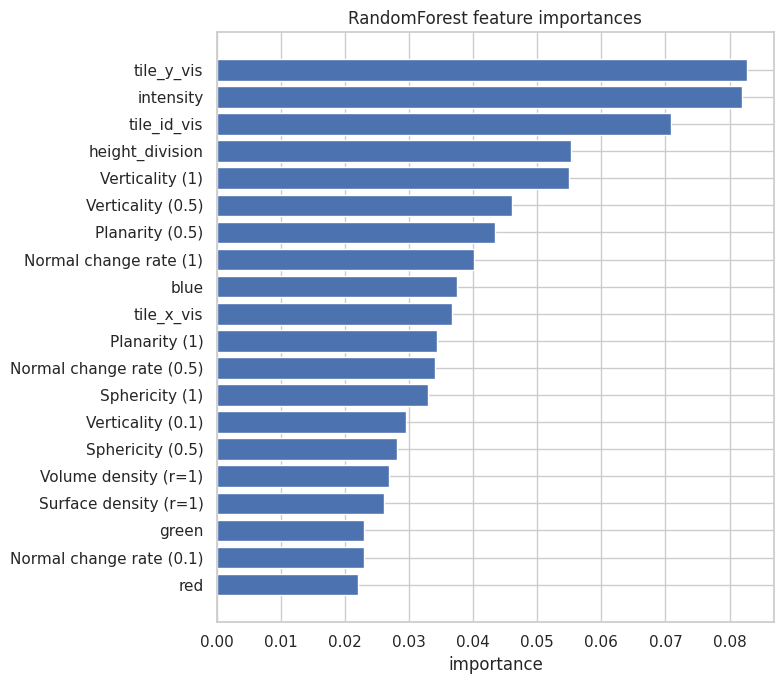

Rendering SHAP summary plot for Experiment A (may take time)...


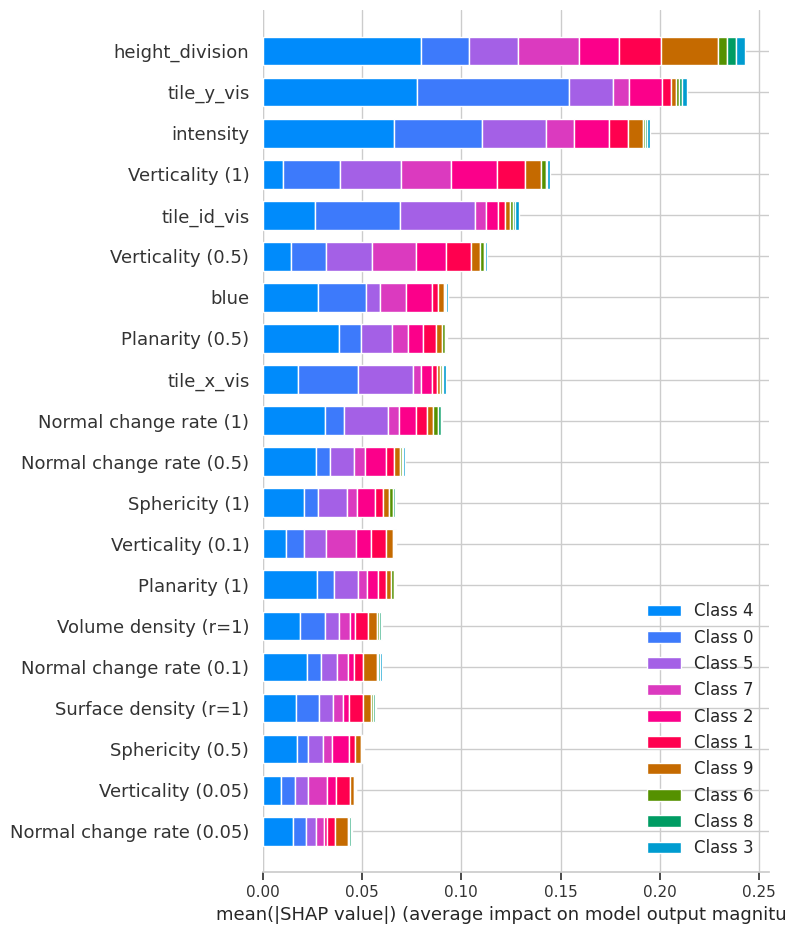


=== Experiment B: Spatial holdout (model_b) ===


,feature,importance
0,tile_id_vis,0.093794
1,intensity,0.071346
2,tile_y_vis,0.062317
3,tile_x_vis,0.059322
4,Verticality (1),0.053144
5,Verticality (0.5),0.042362
6,Normal change rate (1),0.041811
7,Sphericity (1),0.037975
8,height_division,0.033787
9,Normal change rate (0.5),0.033120


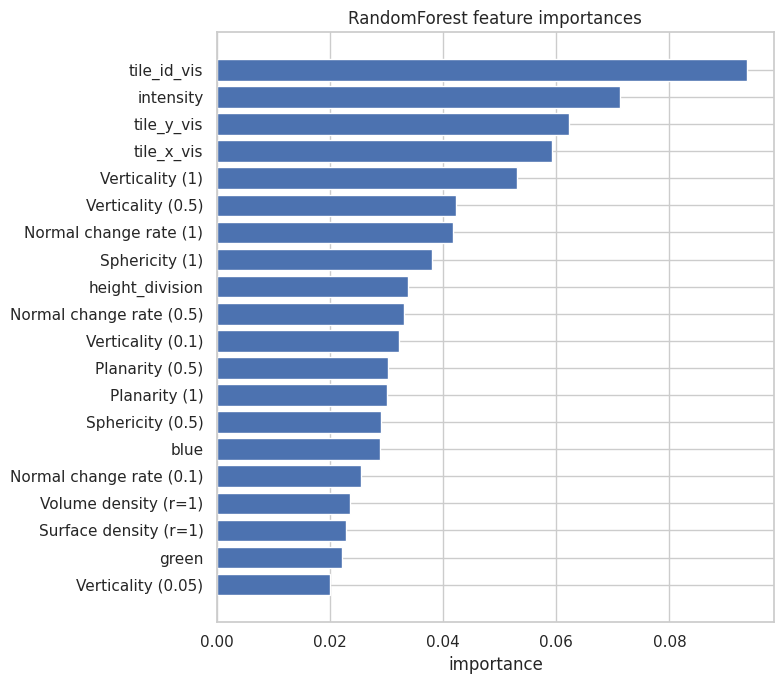

Rendering SHAP summary plot for Experiment B (may take time)...


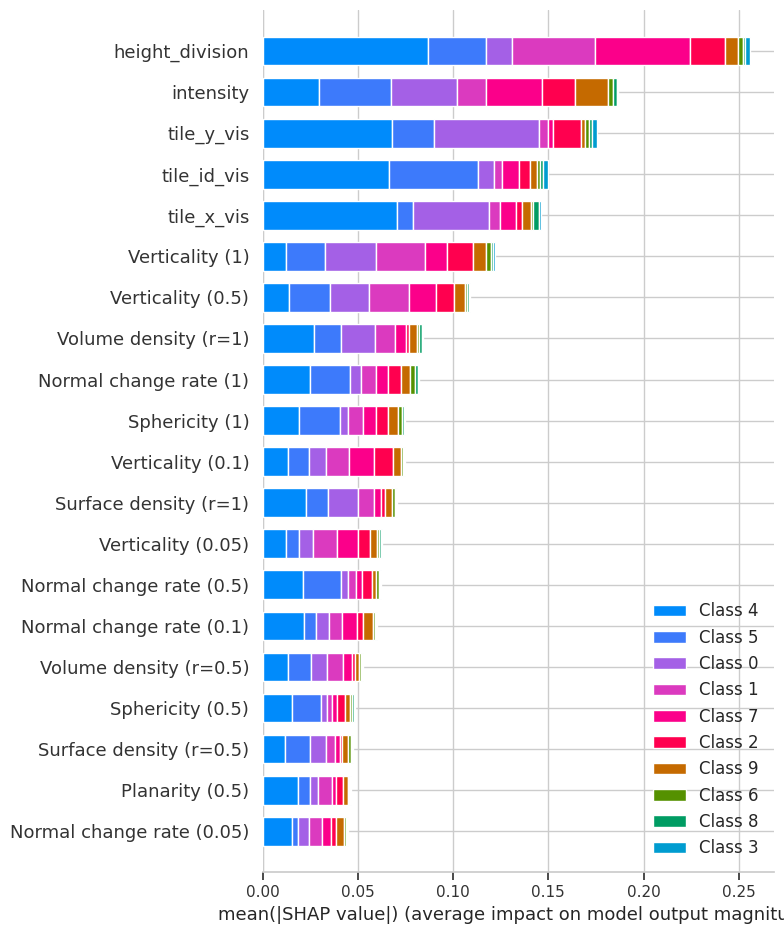

In [16]:
# Feature importance: RandomForest importances and SHAP summary (if available)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def show_rf_importances(model, features, topk=20):
    imp = model.feature_importances_
    df_imp = pd.DataFrame({'feature': features, 'importance': imp})
    df_imp = df_imp.sort_values('importance', ascending=False).reset_index(drop=True)
    display(df_imp.head(topk))
    plt.figure(figsize=(8, min(0.35*topk, 8)))
    plt.barh(df_imp['feature'].head(topk)[::-1], df_imp['importance'].head(topk)[::-1])
    plt.xlabel('importance')
    plt.title('RandomForest feature importances')
    plt.tight_layout()
    plt.show()

# Show for Experiment A
print('\n=== Experiment A: Random sampling (model_a) ===')
try:
    show_rf_importances(model_a, MODEL_FEATURES, topk=20)
except Exception as e:
    print('Could not compute RF importances for model_a:', e)

# SHAP for Experiment A (if available)
if 'shap' in globals() and shap is not None and 'explainer_a' in globals() and explainer_a is not None and 'shap_vals_a' in globals() and shap_vals_a is not None:
    try:
        X_test_s = scaler_a.transform(X_test)
        # determine subset length used to compute shap_vals_a
        if isinstance(shap_vals_a, list):
            nrows = shap_vals_a[0].shape[0]
        else:
            nrows = shap_vals_a.shape[0]
        subset = X_test_s[:nrows]
        print('Rendering SHAP summary plot for Experiment A (may take time)...')
        shap.summary_plot(shap_vals_a, subset, feature_names=MODEL_FEATURES)
    except Exception as e:
        print('SHAP plot failed for Experiment A:', e)
else:
    print('SHAP not available or not computed for Experiment A')

# Show for Experiment B
print('\n=== Experiment B: Spatial holdout (model_b) ===')
try:
    show_rf_importances(model_b, MODEL_FEATURES, topk=20)
except Exception as e:
    print('Could not compute RF importances for model_b:', e)

# SHAP for Experiment B
if 'shap' in globals() and shap is not None and 'explainer_b' in globals() and explainer_b is not None and 'shap_vals_b' in globals() and shap_vals_b is not None:
    try:
        X_test_b_s = scaler_b.transform(X_test_b)
        if isinstance(shap_vals_b, list):
            nrows = shap_vals_b[0].shape[0]
        else:
            nrows = shap_vals_b.shape[0]
        subset_b = X_test_b_s[:nrows]
        print('Rendering SHAP summary plot for Experiment B (may take time)...')
        shap.summary_plot(shap_vals_b, subset_b, feature_names=MODEL_FEATURES)
    except Exception as e:
        print('SHAP plot failed for Experiment B:', e)
else:
    print('SHAP not available or not computed for Experiment B')

In [17]:
model_a

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



CONFUSION MATRICES

=== Experiment A: Random Sampling ===


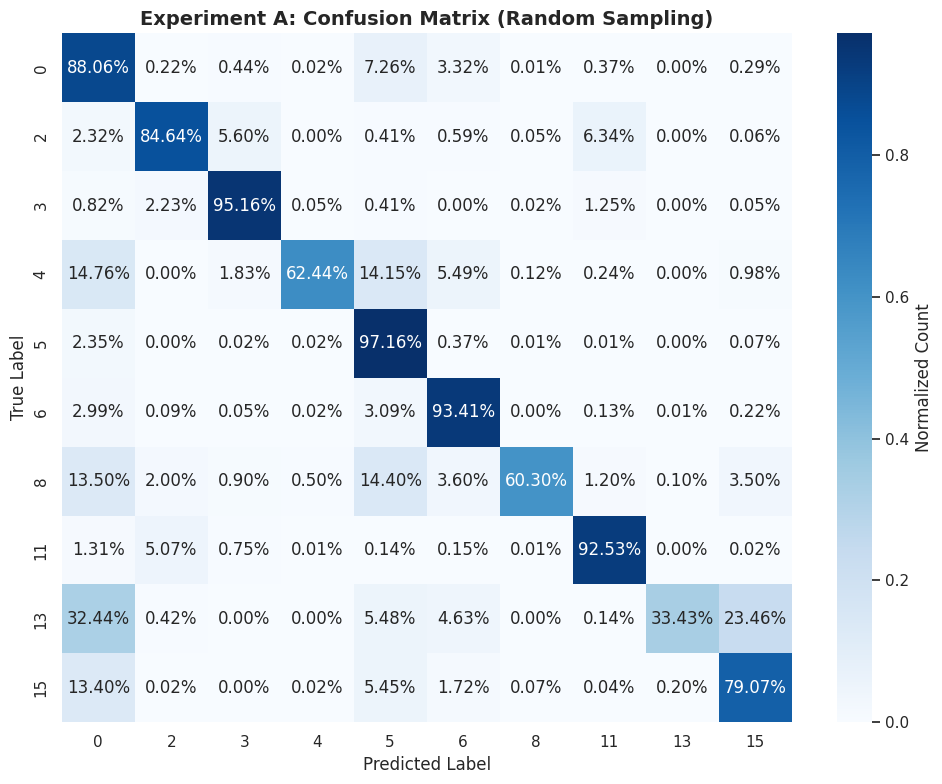


=== Experiment B: Spatial Holdout ===


invalid value encountered in divide


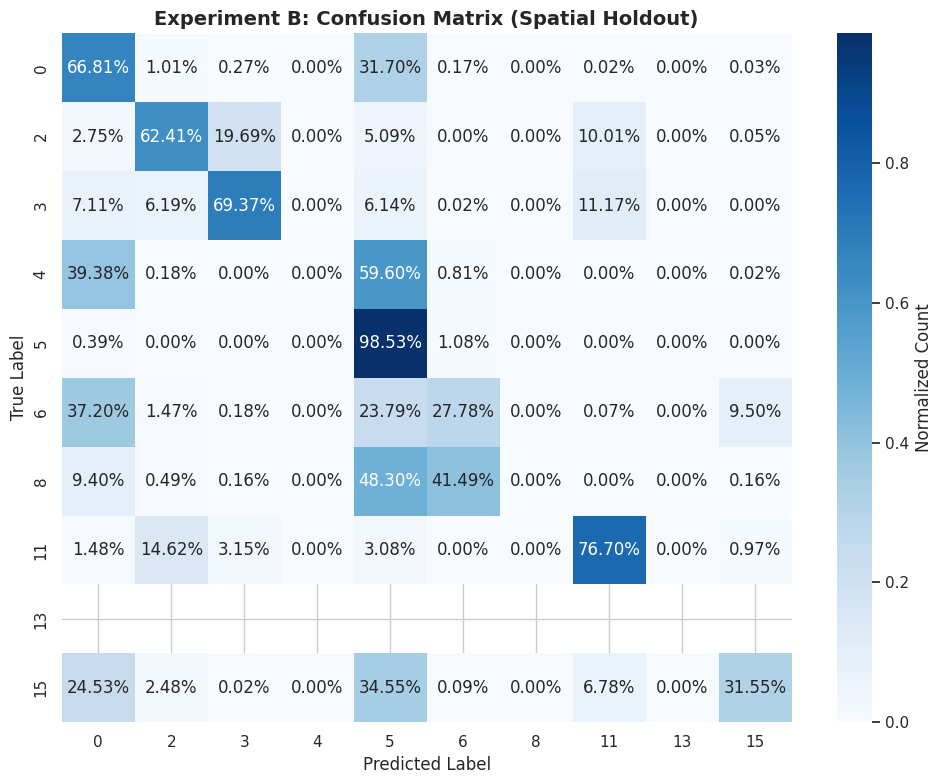

In [18]:
# Plot confusion matrices for both experiments
print('\n' + '='*50)
print('CONFUSION MATRICES')
print('='*50)

# Experiment A - Random sampling
if 'cm_a' in globals() and 'classes_a' in globals():
    print('\n=== Experiment A: Random Sampling ===')
    plot_confusion_matrix(cm_a, classes_a, 
                         title='Experiment A: Confusion Matrix (Random Sampling)', 
                         normalize=True, figsize=(10, 8))
else:
    print('Confusion matrix for Experiment A not available')

# Experiment B - Spatial holdout
if 'cm_b' in globals() and 'classes_b' in globals():
    print('\n=== Experiment B: Spatial Holdout ===')
    plot_confusion_matrix(cm_b, classes_b, 
                         title='Experiment B: Confusion Matrix (Spatial Holdout)', 
                         normalize=True, figsize=(10, 8))
else:
    print('Confusion matrix for Experiment B not available')


Still need to work out why we're missing class 13, and what's going on with these predictions...

## When moving onto DL: PointNet++ / KPConv / RandLA-Net learn spatial location and feature automated edge detection

## Visualising the pointclouds

## Plotly visualization of Experiment A results

This cell visualizes a random sample of points from Experiment A, colored by class, but only where the true label matches the predicted label. Points where the prediction was incorrect are shown as a separate class. This helps to visually assess the model's performance and spatial distribution of correct/incorrect predictions.

The function will attempt to use o3d to view the pointcloud if you have a graphical interface. Failing this, we use plotly as this allows inline viewing.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import open3d as o3d

##############################--- Parameters --- ####################################
SAMPLE_SIZE = 50000  # Adjust as needed for memory
POINT_SIZE = 1  # Smaller points for better visibility
TILE_ID = None  # 0_2', '0_3', '1_0', '1_1', '1_2', '1_3', '2_0', '2_1', '2_2', '2_3', '3_0', '3_2', '3_3'or None for all tiles
CLASSES = [11,2]  # Set to list of classes to include (e.g. [1,2]) or None for all
#Z_MAX = 100000  # Cut off points above this Z, to remove buildings and tall trees.
######################################################################################

# --- Prepare Data ---
true_labels = np.array(y_test)
pred_labels = np.array(y_pred_a)
min_len = min(len(true_labels), len(pred_labels), X_test.shape[0])
true_labels = true_labels[:min_len]
pred_labels = pred_labels[:min_len]
X_test_indices = X_test.index[:min_len]

# Use z-cutoff filtered df if available (for visualization only)
source_df = df_vis if 'df_vis' in globals() else df

# Apply hard Z cutoff for visualization
#source_df = source_df[source_df['Z'] <= Z_MAX]

if CLASSES is not None:
    class_mask = np.isin(true_labels, CLASSES)
    true_labels = true_labels[class_mask]
    pred_labels = pred_labels[class_mask]
    X_test_indices = X_test_indices[class_mask]

# Align indices with source_df (in case z-cutoff removed some points)
valid_mask = np.isin(X_test_indices, source_df.index)
valid_idx = X_test_indices[valid_mask]
true_labels = true_labels[valid_mask]
pred_labels = pred_labels[valid_mask]
coords_df = source_df.loc[valid_idx, COORD_COLS].reset_index(drop=True)

# --- Tile assignment for visualization ---
xmin, xmax = source_df['X'].min(), source_df['X'].max()
ymin, ymax = source_df['Y'].min(), source_df['Y'].max()
x_edges = np.linspace(xmin, xmax, N_TILES_X + 1)
y_edges = np.linspace(ymin, ymax, N_TILES_Y + 1)

tx = np.digitize(coords_df['X'].values, x_edges) - 1
ty = np.digitize(coords_df['Y'].values, y_edges) - 1

tx = np.clip(tx, 0, N_TILES_X - 1)
ty = np.clip(ty, 0, N_TILES_Y - 1)

coords_df['tile_id'] = (
    pd.Series(tx, index=coords_df.index).astype(str)
    + '_'
    + pd.Series(ty, index=coords_df.index).astype(str)
)

if TILE_ID is not None:
    tile_mask = coords_df['tile_id'] == TILE_ID
    if tile_mask.sum() == 0:
        raise ValueError(f"No points found for TILE_ID={TILE_ID}. Available tiles: {sorted(coords_df['tile_id'].unique())}")
    coords_df = coords_df.loc[tile_mask].reset_index(drop=True)
    true_labels = true_labels[tile_mask]
    pred_labels = pred_labels[tile_mask]

correct_mask = (true_labels == pred_labels)
plot_labels = np.where(correct_mask, true_labels, -1)

if len(plot_labels) > SAMPLE_SIZE:
    sample_idx = np.random.choice(len(plot_labels), SAMPLE_SIZE, replace=False)
else:
    sample_idx = np.arange(len(plot_labels))

coords = coords_df.iloc[sample_idx][COORD_COLS].values
plot_df = pd.DataFrame(coords, columns=COORD_COLS)
plot_df['class'] = plot_labels[sample_idx].astype(int).astype(str)

unique_classes = np.unique(true_labels)
color_names = [str(int(c)) for c in unique_classes]
color_discrete_map = {str(int(c)): px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] for i, c in enumerate(unique_classes)}
color_discrete_map['-1'] = 'black'

# --- Try Open3D visualization ---
def try_open3d_pointcloud(plot_df, color_discrete_map):
    try:
        # Map class to color
        color_map = {k: np.array(px.colors.hex_to_rgb(v))/255.0 for k, v in color_discrete_map.items()}
        colors = np.array([color_map.get(cls, [0, 0, 0]) for cls in plot_df['class']])
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(plot_df[COORD_COLS].values)
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])
        print("Open3D visualization succeeded.")
        return True
    except Exception as e:
        print(f"Open3D visualization failed: {e}\nFalling back to Plotly.")
        return False

# --- Visualize ---
if not try_open3d_pointcloud(plot_df, color_discrete_map):
    title = 'Experiment A: 3D Point Cloud (Correct vs Incorrect Predictions)'
    if TILE_ID is not None:
        title += f" — Tile {TILE_ID}"
    fig = px.scatter_3d(
        plot_df,
        x=COORD_COLS[0],
        y=COORD_COLS[1],
        z=COORD_COLS[2] if len(COORD_COLS) > 2 else None,
        color='class',
        color_discrete_map=color_discrete_map,
        category_orders={'class': color_names + ['-1']},
        title=title,
        opacity=0.7,
        height=700
    )
    fig.update_traces(marker=dict(size=POINT_SIZE)) # change the point sizes
    fig.update_layout(scene_aspectmode='data') # This flattens the data, so that Z isn't so exaggerated
    fig.show()


Open3D visualization failed: invalid literal for int() with base 16: 'l'
Falling back to Plotly.


Figure out whats going on with this. Why are the points so tall?

## (Optional) Save the LAS file to view in third party